In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import cv2 as cv

## Extracting first frame of sample video

In [2]:
video_path = "../videos/jog.mp4"
out_path = "../out/presentation/"

In [3]:
video = cv.VideoCapture(video_path)

ret, frame = video.read()

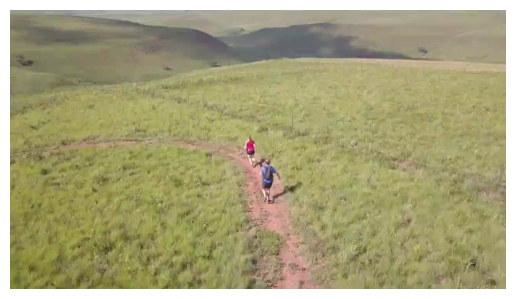

In [4]:
fig = plt.figure()
plt.axis("off")
plt.imshow(frame[:,:,::-1])
plt.show()
fig.savefig(out_path + "og.png", dpi = fig.dpi, bbox_inches='tight')

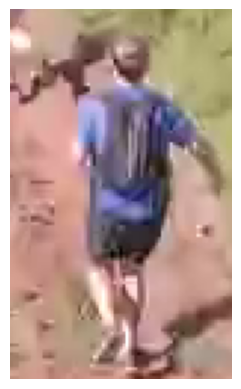

In [5]:
x, y, w, h = 625, 375, 75, 125
zoomed = frame[y : y + h, x : x + w, :]

fig = plt.figure()
plt.axis("off")
plt.imshow(zoomed[:, :, ::-1])
plt.show()
fig.savefig(out_path + "zoomed.png", dpi = fig.dpi, bbox_inches='tight')

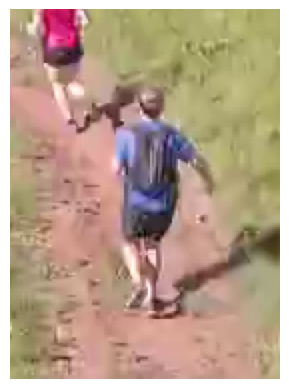

In [6]:
extend_x, extend_y = 30, 30
xp, yp, wp, hp = 625 - extend_x, 375 - extend_y, 75 + 2 * extend_x, 125 + 2 * extend_y

search_area = frame[yp : yp + hp, xp : xp + wp, :]

fig = plt.figure()
plt.axis("off")
plt.imshow(search_area[:, :, ::-1])
plt.show()
fig.savefig(out_path + "search.png", dpi = fig.dpi, bbox_inches='tight')

## Fuzzy C mean

[documentation](https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html)

In [7]:
n_clusters = 2
colour_map = ["#440154FF", "#414487FF", "2A788EFF", "#22A884FF", "#7AD151FF", "#FDE725FF"]

[viridis colours](https://rpubs.com/mjvoss/psc_viridis)

In [8]:
def to_rgb(hex : str):
    substr = hex.replace("#", "")

    r = int(substr[0:2], 16)
    g = int(substr[2:4], 16)
    b = int(substr[4:6], 16)

    return [r, g, b]



def render_cluster(filename, n_clusters, u, img_shape):
    cluster_membership = np.argmax(u, axis = 0)
    segmented_image = cluster_membership.reshape(img_shape)

    map_frac = np.floor(len(colour_map) / n_clusters).astype(int)
    my_colour_map = colour_map[0: map_frac * n_clusters : map_frac]

    colored_segmented_image = np.zeros(img_shape + (3, ))

    for i in range(n_clusters):
        colored_segmented_image[segmented_image == i] = np.array(to_rgb(my_colour_map[i])) / 256.0

    fig = plt.figure()
    plt.axis("off")
    plt.imshow(colored_segmented_image[:, :, ::])
    plt.show()
    fig.savefig(filename, dpi = fig.dpi, bbox_inches = "tight")

### Zoomed

In [9]:
pixels = zoomed.reshape(-1, 3)
iter_error = 5e-20
iter_per_step = 1
iter_pow = 1.001

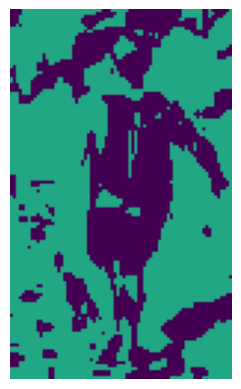

In [10]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(pixels.T, n_clusters, iter_pow, error=iter_error, maxiter=iter_per_step, init=None)

render_cluster(out_path + "c_means_zoom_0.png", n_clusters, u, zoomed.shape[0:2])

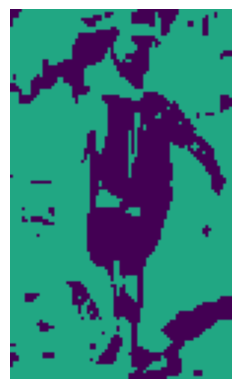

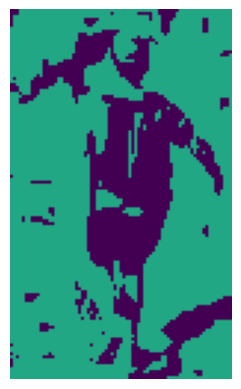

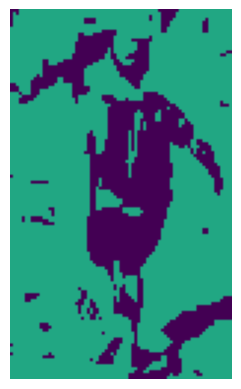

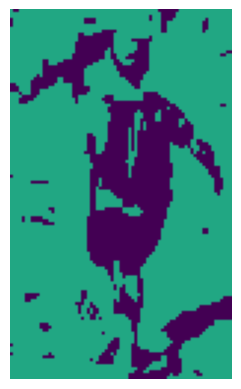

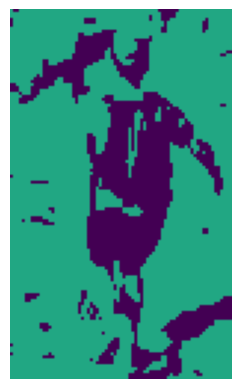

In [11]:
for i in range(1, 6):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(pixels.T, n_clusters, iter_pow, error=iter_error, maxiter=iter_per_step, init=u)
    render_cluster(out_path + f"c_means_zoom_{i}.png", n_clusters, u, zoomed.shape[0:2])

### Search

In [12]:
pixels = search_area.reshape(-1, 3)
iter_error = 5e-20
iter_per_step = 1
iter_pow = 1.001

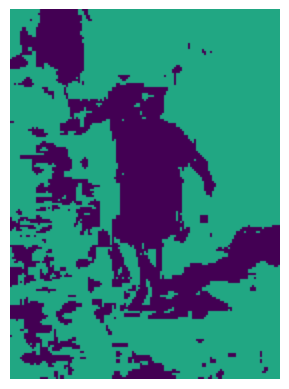

In [13]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(pixels.T, n_clusters, iter_pow, error=iter_error, maxiter=iter_per_step, init=None)

render_cluster(out_path + "c_means_search_0.png", n_clusters, u, search_area.shape[0:2])

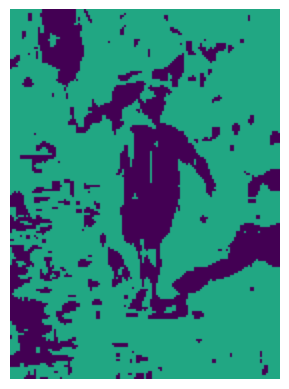

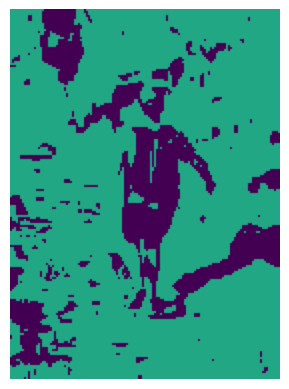

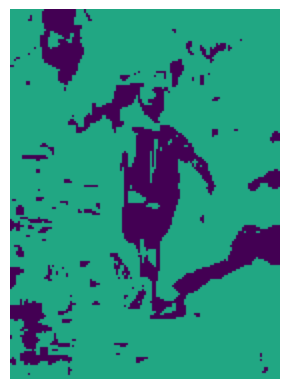

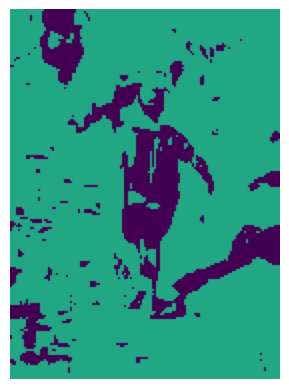

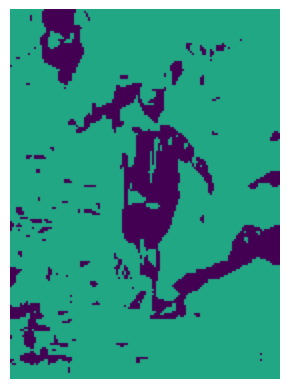

In [14]:
for i in range(1, 6):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(pixels.T, n_clusters, iter_pow, error=iter_error, maxiter=iter_per_step, init=u)
    render_cluster(out_path + f"c_means_search_{i}.png", n_clusters, u, search_area.shape[0:2])

## Watershed algorithm

In [15]:
zoomed_cp = np.copy(zoomed)

gray = cv.cvtColor(zoomed_cp, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [16]:
# noise removal
kernel = np.ones((4, 4), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN,kernel, iterations = 2)
 
# sure background area
sure_bg = cv.dilate(opening,kernel, iterations=3)
 
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening, cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform, 0.01*dist_transform.max(), 255, 0)
 
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

In [17]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
 
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
 
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [18]:
markers = cv.watershed(zoomed_cp, markers)

zoomed_cp[markers == -1] = [0, 0, 255]

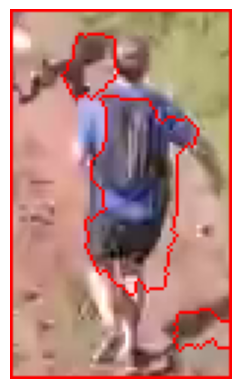

In [19]:
fig = plt.figure()
plt.axis("off")
plt.imshow(zoomed_cp[:, :, ::-1])
plt.show()
fig.savefig(out_path + "watershed.png", dpi = fig.dpi, bbox_inches='tight')